In [51]:
import sys
import time
import os
import stim
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pymatching
import subprocess
# import chromobius

sys.path.insert(0, os.path.abspath('/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/stabilizer/src'))

import surface_code as sc
import noise_util as ns
import tomography_util as tm
importlib.reload(sc)
importlib.reload(ns)
importlib.reload(tm)

<module 'tomography_util' from '/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/stabilizer/src/tomography_util.py'>

In [52]:
# Experiment Parameters
SHOTS = 100000
BASE_ERROR = 0.001
DISTANCES = [3]#, 5, 7] #, 11]
T1 = 10 ** -4
T2 = 5 * 10 ** -5
tau = 10**-6
lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
compile_command = [
    "/opt/homebrew/bin/mpicxx",  # use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-DMPI_ENABLED",
    "-o",
    "noisy_code_sim",
    "noisy_code_sim.cpp"
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation failed.
--- stdout ---

--- stderr ---
In file included from noisy_code_sim.cpp:19:
./../../include/stabsim/src/qasm_extraction.hpp:8:10: fatal error: '../../include/backendManager.hpp' file not found
    8 | #include "../../include/backendManager.hpp"
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 error generated.



In [53]:
def run_single_distance_experiment(distance, shots, base_error):
    """
    Runs the entire simulation and analysis pipeline for a single code distance.
    Returns a dictionary containing the logical error and post-selection rates for both simulators.
    """
    print(f"\n--- Running for Distance = {distance} ---")
    
    # 1. Generate Circuit and Noise Model
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=distance,
        distance=distance
    )
    model = ns.ErrorModel(circuit)
    model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    model.setting_error('Reset', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    stim_circuit = model.generate_noisy_circuit()

    # 2. Stim Simulation and Analysis
    print("Running Stim simulation...")
    stim_sampler = stim_circuit.compile_detector_sampler()
    start_time = time.perf_counter()
    stim_det_samples, stim_obs_flips = stim_sampler.sample(shots, separate_observables=True, bit_packed=False)
    end_time = time.perf_counter()
    stim_time = end_time-start_time
    
    dem = stim_circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching.from_detector_error_model(dem)
    
    stim_errors = 0
    stim_post_selected = 0
    for i in range(shots):
        if np.sum(stim_det_samples[i]) % 2 == 0:
            stim_post_selected += 1
            prediction = matching.decode(stim_det_samples[i])
            if prediction[0] != stim_obs_flips[i][0]:
                stim_errors += 1
    
    stim_ler = stim_errors / stim_post_selected if stim_post_selected > 0 else 0
    stim_psr = stim_post_selected / shots if shots > 0 else 0
    print(f"Stim LER: {stim_ler:.4f}, Post-selection Rate: {stim_psr:.4f}, Sim Time: {stim_time:.4f}s")

    # 3. C++ Simulation and Analysis (MPI)
    
    stab_circuit = stim_circuit

    print("Running C++ simulation (MPI)...")
    qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
    qasm_file_path = "./surface_code_qasm/surface_code.qasm"
    cpp_output_path = "./surface_code_qasm/measurement_results.txt" 
    with open(qasm_file_path, "w") as f:
        f.write(qasm_output)
        
    num_qubits = stab_circuit.num_qubits
    run_command = [
        "/opt/homebrew/bin/mpirun", "-np", str(1),  # choose a reasonable default
        "./noisy_code_sim", str(num_qubits), str(shots), qasm_file_path, cpp_output_path
    ]
    try:
        result = subprocess.run(run_command, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print("C++ simulation failed to execute.")
        print("Return code:", e.returncode)
        print("--- stdout ---")
        print(e.stdout)
        print("--- stderr ---")
        print(e.stderr)
        return {
            "stim_ler": stim_ler, "stim_psr": stim_psr, "stim_time": stim_time,
            "cpp_ler": 0, "cpp_psr": 0, "cpp_time": 0,
        }

    cpp_time = 0.0
    for line in result.stdout.strip().split('\n'):
        if "Total C++ simulation time" in line:
            try:
                cpp_time = float(line.split(':')[1].strip().replace('s', ''))
            except (ValueError, IndexError):
                pass # Ignore parsing errors

    cpp_ler = 0
    cpp_psr = 0
    try:
        with open(cpp_output_path, "r") as f:
            measurement_strings = [line for line in f.read().strip().split('\n') if line]
        
        if measurement_strings:
            measurement_data = np.array([line.split() for line in measurement_strings], dtype=int).astype(bool)
            
            m2d_converter = stab_circuit.compile_m2d_converter()
            cpp_det_samples, cpp_obs_flips = m2d_converter.convert(measurements=measurement_data, separate_observables=True)
            
            cpp_errors = 0
            cpp_post_selected = 0
            for i in range(len(cpp_det_samples)):
                if np.sum(cpp_det_samples[i]) % 2 == 0:
                    cpp_post_selected += 1
                    prediction = matching.decode(cpp_det_samples[i])
                    if prediction[0] != cpp_obs_flips[i][0]:
                        cpp_errors += 1
            
            cpp_ler = cpp_errors / cpp_post_selected if cpp_post_selected > 0 else 0
            cpp_psr = cpp_post_selected / len(cpp_det_samples) if len(cpp_det_samples) > 0 else 0
    except FileNotFoundError:
        print("C++ output file not found. Skipping analysis.")

    print(f"C++ LER: {cpp_ler:.4f}, Post-selection Rate: {cpp_psr:.4f}, Sim Time: {cpp_time:.4f}s")

    return {
        "stim_ler": stim_ler, "stim_psr": stim_psr,

        "cpp_ler": cpp_ler, "cpp_psr": cpp_psr,
        "cpp_time": cpp_time, "stim_time": stim_time,
    }

In [54]:
# # --- Main Loop ---
# Result storage
stim_logical_error_rates = []
cpp_logical_error_rates = []
stim_post_selection_rates = []
cpp_post_selection_rates = []

# print(DISTANCES)
for d in DISTANCES:
    rates = run_single_distance_experiment(d, SHOTS, BASE_ERROR)
    stim_logical_error_rates.append(rates["stim_ler"])
    stim_post_selection_rates.append(rates["stim_psr"])
    cpp_logical_error_rates.append(rates["cpp_ler"])
    cpp_post_selection_rates.append(rates["cpp_psr"])



print("\n--- Experiment Complete ---")
print("Distances:", DISTANCES)
print("Stim LERs:", stim_logical_error_rates)
print("C++ LERs:", cpp_logical_error_rates)
print("Stim PSRs:", stim_post_selection_rates)
print("C++ PSRs:", cpp_post_selection_rates)




--- Running for Distance = 3 ---
Running Stim simulation...
Stim LER: 0.0005, Post-selection Rate: 0.8933, Sim Time: 0.0085s
Running C++ simulation (MPI)...
C++ LER: 0.0000, Post-selection Rate: 1.0000, Sim Time: 14.2425s

--- Experiment Complete ---
Distances: [3]
Stim LERs: [0.0005373455131649651]
C++ LERs: [0.0]
Stim PSRs: [0.89328]
C++ PSRs: [1.0]


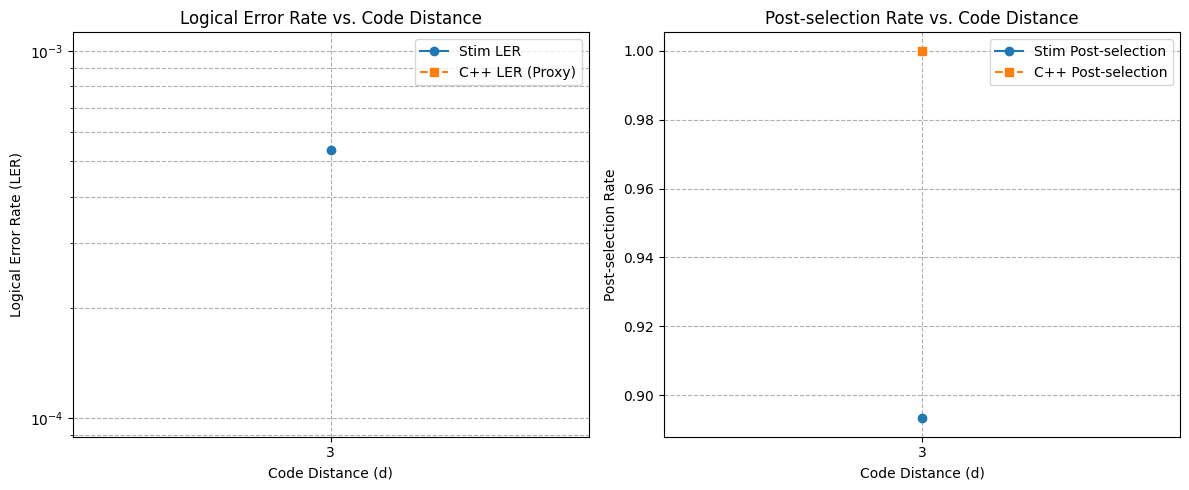

In [55]:
# --- Plotting Results ---
plt.figure(figsize=(12, 5))

# Plot 1: Logical Error Rate vs. Distance
plt.subplot(1, 2, 1)
plt.plot(DISTANCES, stim_logical_error_rates, 'o-', label='Stim LER')
plt.plot(DISTANCES, cpp_logical_error_rates, 's--', label='C++ LER (Proxy)')
plt.xlabel("Code Distance (d)")
plt.ylabel("Logical Error Rate (LER)")
plt.title("Logical Error Rate vs. Code Distance")
plt.yscale('log')
# plt.ylim(10**-10)
plt.xticks(DISTANCES)
plt.grid(True, which="both", ls="--")
plt.legend()

# Plot 2: Post-selection Rate vs. Distance
plt.subplot(1, 2, 2)
plt.plot(DISTANCES, stim_post_selection_rates, 'o-', label='Stim Post-selection')
plt.plot(DISTANCES, cpp_post_selection_rates, 's--', label='C++ Post-selection')
plt.xlabel("Code Distance (d)")
plt.ylabel("Post-selection Rate")
plt.title("Post-selection Rate vs. Code Distance")
plt.xticks(DISTANCES)
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()
plt.show()
